In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = (10, 5)

## OFDM demodulation

In [2]:
fs = 30720000

T = 1
x = np.fromfile('record_2022-04-09T11:09:29.569565', 'int16', count=int(T*fs*2))

# Scale amplitude
x = (x[::2] + 1j*x[1::2])/2e6

delta_f = -1232
delta_phi = 2.03
samp_rate_error = 1 - 1.5e-6

x *= np.exp(1j*(2*np.pi*delta_f/fs*np.arange(x.size) + delta_phi))

In [3]:
# The units here are samples
Tu = 2048 # useful time of a symbol
cp_len = 144  # 4.7 usecs, used in symbols 1-6 in a slot
cp_len2 = 160  # 5.2 usecs, used in symbol 0 in a slot

In [4]:
# Sample of start of the PSS
a0 = 72056
# Sample of start of slot including PSS (not including 1st cyclic prefix)
a1 = a0 - 6 * cp_len - 6 * Tu
# Number of full slots before PSS subframe
samp_per_slot = int(0.5e-3 * fs)
n_full_slot = a1 // samp_per_slot
# Sample of start of first full slot (not including 1st cyclic prefix)
a2 = a1 - n_full_slot * samp_per_slot
a2

12824

In [5]:
# Total number of full slots in the recording
slots = (x.size - a2) // samp_per_slot
nsymbols = slots * 7

# Selection of subcarriers in use
NRB = 50  # Number of resource blocks for a 10 MHz cell
sel_syms = np.arange(Tu//2 - NRB//2 * 12, Tu//2 + NRB//2 * 12 + 1)
no_dc = np.concatenate((np.arange(0, NRB//2 * 12), np.arange(NRB//2 * 12 + 1, NRB * 12 + 1)))

freq_syms = np.fft.fftshift(np.fft.fftfreq(Tu, 1/fs))
freq_syms = freq_syms[sel_syms]

# Extract OFDM symbols
symbols = np.empty((nsymbols, sel_syms.size), 'complex64')
for j in range(nsymbols):
    # For each slot, we need to advance cp_len2-cp_len because of the
    # longer cyclic prefix of the first symbol in each slot. delta counts
    # this.
    delta = (cp_len2 - cp_len) * (j//7)
    
    exact_sample = j*(Tu+cp_len)*samp_rate_error
    round_sample = round(exact_sample)
    error_sample = exact_sample - round_sample
    syms = np.fft.fftshift(np.fft.fft(x[a2+round_sample+delta:][:Tu]))
    # Correct for fractional sample delay
    syms *= np.exp(1j*2*np.pi*error_sample*np.arange(-Tu//2, Tu//2)/Tu)
    symbols[j] = syms[sel_syms]

## CRS

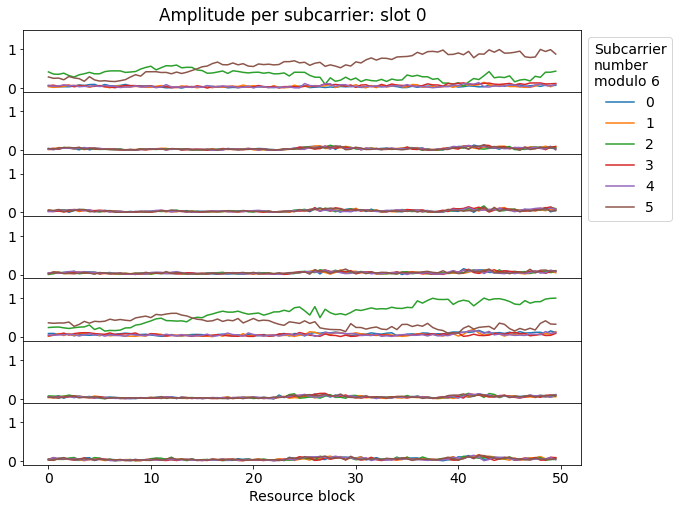

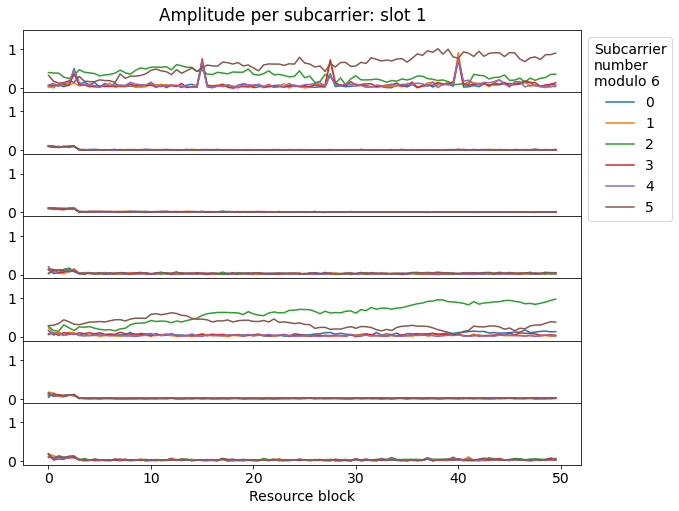

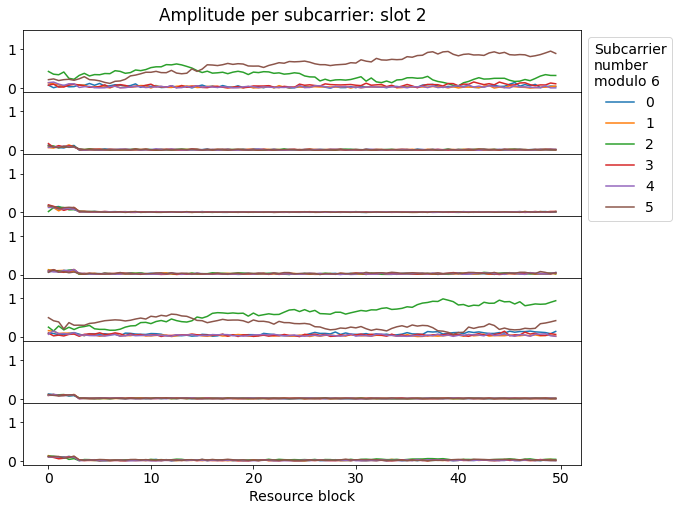

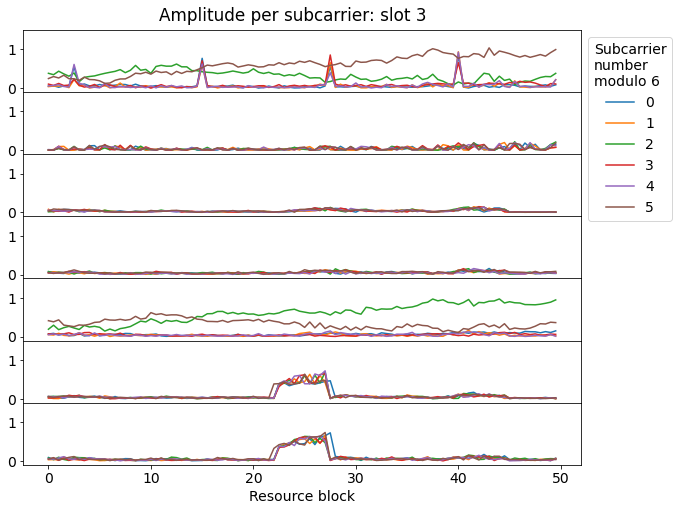

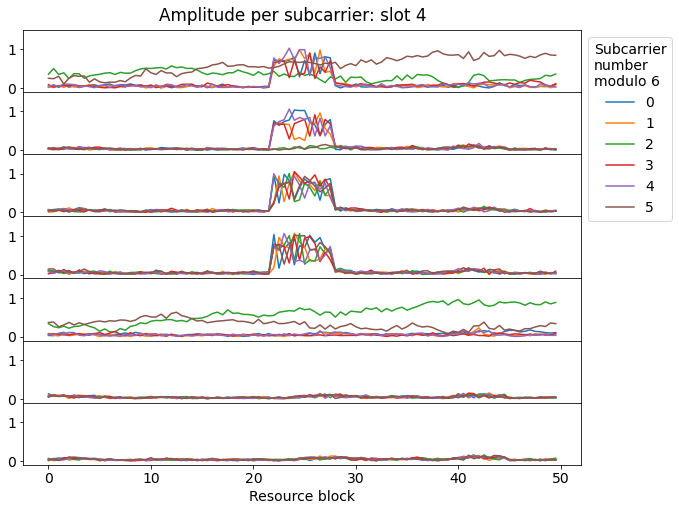

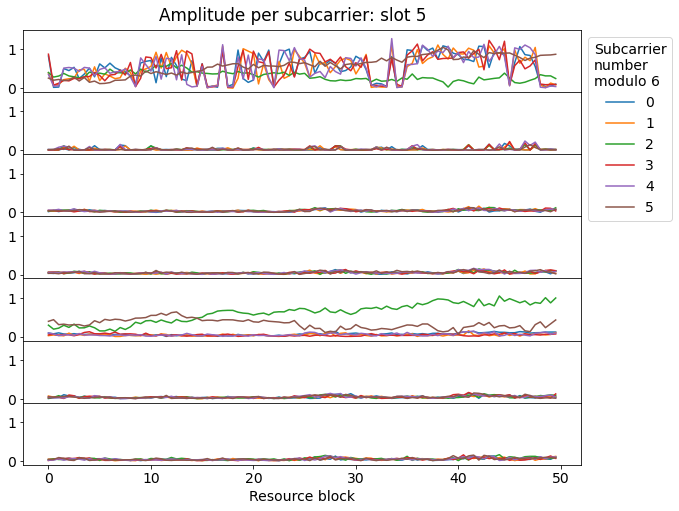

In [6]:
for slot in range(6):
    fig, axs = plt.subplots(7, 1, figsize=(10, 8), sharex=True, sharey=True)
    for j, ax in enumerate(axs):
        for k in range(6):
            n = np.arange(0, NRB, 0.5)
            ax.plot(n, np.abs(symbols[7 * slot + j, no_dc][k::6]),
                    label=f'{k}')
        ax.set_yticks([0, 1.0])
    plt.ylim((-0.1, 1.5))
    plt.xlabel('Resource block')
    plt.suptitle(f'Amplitude per subcarrier: slot {slot}', y=0.92)
    plt.legend(bbox_to_anchor=(1, 7), loc='upper left', title='Subcarrier\nnumber\nmodulo 6')
    plt.subplots_adjust(hspace=0)

In [7]:
# Psedurandom sequence following Section 7.2 in 3GPP TS 36.211
def c_seq(c_init, M_PN):
    x1 = 1
    x2 = c_init
    NC = 1600
    c = np.zeros(M_PN, 'uint8')
    # Drop the first NC terms
    for j in range(NC + M_PN):
        if j >= NC:
            c[j - NC] = (x1 ^ x2) & 1
        x1 = (((x1 ^ (x1 >> 3)) & 1) << 30) | (x1 >> 1)
        x2 = (((x2 ^ (x2 >> 1) ^ (x2 >> 2) ^ (x2 >> 3)) & 1) << 30) | (x2 >> 1)
    return c

# QPSK sequence for CRS
def r_seq(ns, l, pci=380):
    NCP = 1  # normal cyclic prefix
    NRBmaxDL = 110
    c_init_rs = 2**10 * (7 * (ns + 1) + l + 1) * (2 * pci + 1) + 2 * pci + NCP
    c = c_seq(c_init_rs, 4 * NRBmaxDL)
    cc = (1 - 2 * c.astype('float')) / np.sqrt(2)
    r = cc[::2] + 1j * cc[1::2]
    return r[NRBmaxDL-NRB:-(NRBmaxDL-NRB)]

In [8]:
# Wipe off QPSK sequence in CRS
# We also consider the CRS for cells in the same group, but they are too noisy
# to estimate a channel well.
ns0 = 17
r0_wipe = {}
r1_wipe = {}
for pci in [378, 379, 380]:
    r0w = np.empty((slots * 2, 2 * NRB), 'complex')
    r1w = np.empty_like(r0w)
    for j in range(2 *  slots):
        symidx = (j // 2) * 7 + 4 * (j % 2)
        nu = (pci + 3 * (j % 2)) % 6
        ns = (symidx // 7 + ns0) % 20
        r = r_seq(ns, symidx % 7, pci=pci)
        r0w[j] = symbols[symidx, no_dc][nu::6] * np.conjugate(r)
        r1w[j] = symbols[symidx, no_dc][(nu+3)%6::6] * np.conjugate(r)
    r0_wipe[pci] = r0w
    r1_wipe[pci] = r1w

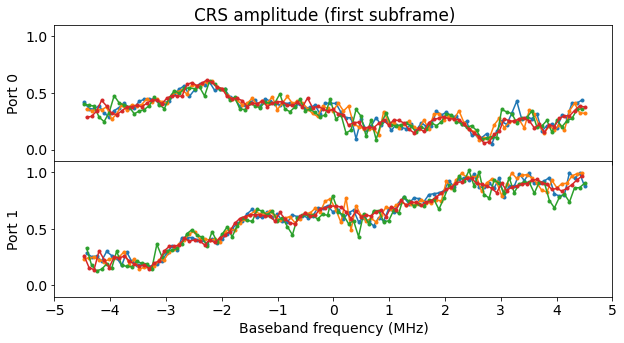

In [9]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for j in range(4):
    nu = (pci + (j % 2)*3) % 6
    f = freq_syms[no_dc][nu::6] * 1e-6
    axs[0].plot(f, np.abs(r0_wipe[380][j]), '.-')
    f = freq_syms[no_dc][(nu+3)%6::6] * 1e-6
    axs[1].plot(f, np.abs(r1_wipe[380][j]), '.-')
plt.ylim((-0.1, 1.1))
plt.subplots_adjust(hspace=0)
plt.xticks(np.arange(-5, 6))
for j in range(2):
    axs[j].set_ylabel(f'Port {j}')
plt.xlabel('Baseband frequency (MHz)')
plt.suptitle('CRS amplitude (first subframe)', y=0.93);

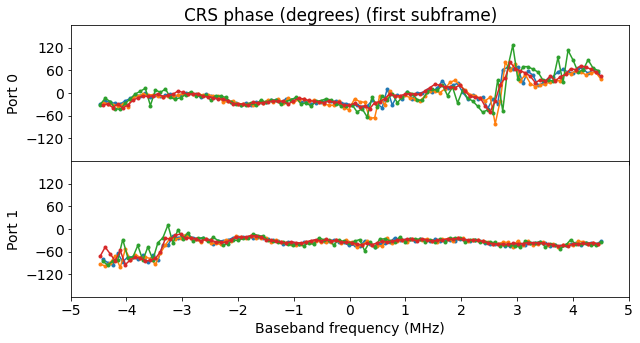

In [10]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for j in range(4):
    nu = (pci + (j % 2)*3) % 6
    f = freq_syms[no_dc][nu::6] * 1e-6
    axs[0].plot(f, np.rad2deg(np.angle(r0_wipe[380][j])), '.-')
    f = freq_syms[no_dc][(nu+3)%6::6] * 1e-6
    axs[1].plot(f, np.rad2deg(np.angle(r1_wipe[380][j])), '.-')
plt.ylim((-180, 180))
plt.subplots_adjust(hspace=0)
plt.yticks(np.arange(-180 + 60, 180, 60))
plt.xticks(np.arange(-5, 6))
for j in range(2):
    axs[j].set_ylabel(f'Port {j}')
plt.xlabel('Baseband frequency (MHz)')
plt.suptitle('CRS phase (degrees) (first subframe)', y=0.93);

## Channel estimation

In [11]:
# Calculation of cubic spline in terms of it coefficients.
# This is used to fit a cubic spline to the channel.
def cubic_spline(coeffs):
    coeffs = coeffs.reshape(-1, 2)
    values = np.empty(NRB * 12, 'complex')
    values = values.reshape(coeffs.shape[0] - 1, -1)
    for j in range(values.shape[0]):
        # p(x) = ax^3 + bx^2 + cx + d
        # a = 2p(0) + p'(0) - 2p(1) + p'(1)
        # b = -3p(0) - 2p'(0) + 3p(1) - p'(1)
        # c = p'(0)
        # d = p(0)
        cf = coeffs[j:j+2].ravel()
        p = np.array([2*cf[0] + cf[1] - 2*cf[2] + cf[3],
                      -3*cf[0] - 2*cf[1] + 3*cf[2] - cf[3],
                      cf[1],
                      cf[0]])
        t = (np.arange(values.shape[1]) + 1) / (values.shape[1] + 1)
        values[j] = np.polyval(p, t)
    # Add central subcarrier (copying the values of the two neighbouring subcarriers)
    values = values.reshape(2, -1)
    return np.concatenate((values[0], [values[0, -1]], values[1]))

ncoeffs = 22
# Matrix for solving the linear least squares fit of the cubic spline
A_cubic_spline = np.array([cubic_spline(np.eye(1, ncoeffs, j)) for j in range(ncoeffs)]).T

In [12]:
# Least squares fit of the cubic spline to the CRS complex amplitudes
r0_fit = {}
r1_fit = {}
for pci in [378, 380]:
    r0f = np.empty((slots * 2, ncoeffs), 'complex')
    r1f = np.empty_like(r0f)
    for j in range(slots * 2):
        nu = pci % 6
        r0f[j] = np.linalg.lstsq(A_cubic_spline[no_dc][nu::6],
                                 r0_wipe[pci][j], rcond=None)[0]
        r1f[j] = np.linalg.lstsq(A_cubic_spline[no_dc][(nu+3)%6::6],
                                 r1_wipe[pci][j], rcond=None)[0]
    r0_fit[pci] = r0f
    r1_fit[pci] = r1f

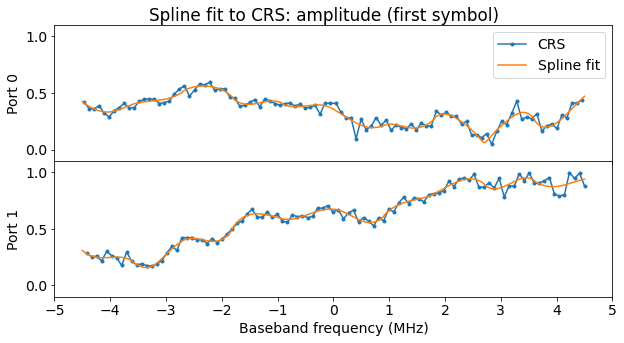

In [13]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
nu = pci % 6
f = freq_syms[no_dc][nu::6] * 1e-6
axs[0].plot(f, np.abs(r0_wipe[380][0]), '.-',
            label='CRS')
axs[0].plot(freq_syms * 1e-6, np.abs(cubic_spline(r0_fit[380][0])),
            label='Spline fit')
axs[0].legend()
f = freq_syms[no_dc][(nu+3)%6::6] * 1e-6
axs[1].plot(f, np.abs(r1_wipe[380][0]), '.-')
axs[1].plot(freq_syms * 1e-6, np.abs(cubic_spline(r1_fit[380][0])))
plt.ylim((-0.1, 1.1))
plt.subplots_adjust(hspace=0)
plt.xticks(np.arange(-5, 6))
for j in range(2):
    axs[j].set_ylabel(f'Port {j}')
plt.xlabel('Baseband frequency (MHz)')
plt.suptitle('Spline fit to CRS: amplitude (first symbol)', y=0.93);

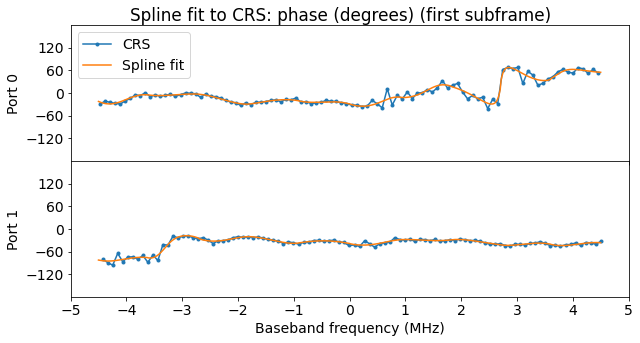

In [14]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
nu = pci % 6
f = freq_syms[no_dc][nu::6] * 1e-6
axs[0].plot(f, np.rad2deg(np.angle(r0_wipe[380][0])), '.-',
            label='CRS')
axs[0].plot(freq_syms * 1e-6, np.rad2deg(np.angle(cubic_spline(r0_fit[380][0]))),
            label='Spline fit')
axs[0].legend()
f = freq_syms[no_dc][(nu+3)%6::6] * 1e-6
axs[1].plot(f, np.rad2deg(np.angle(r1_wipe[380][0])), '.-')
axs[1].plot(freq_syms * 1e-6, np.rad2deg(np.angle(cubic_spline(r1_fit[380][0]))))
plt.ylim((-180, 180))
plt.subplots_adjust(hspace=0)
plt.yticks(np.arange(-180 + 60, 180, 60))
plt.xticks(np.arange(-5, 6))
for j in range(2):
    axs[j].set_ylabel(f'Port {j}')
plt.xlabel('Baseband frequency (MHz)')
plt.suptitle('Spline fit to CRS: phase (degrees) (first subframe)', y=0.93);

In [15]:
# Calculation of channel by linear interpolation of cubic splines fitted to adjacent CRS
def channel(nsymbol, pci=380):
    nslot = nsymbol // 7
    left, adv, dist = (
        (2 * nslot, nsymbol - 7 * nslot, 4)
        if nsymbol % 7 < 4
        else (2 * nslot + 1, nsymbol - 7 * nslot - 4, 3))
    r0 = r0_fit[pci][left] * (1-adv/dist) + r0_fit[pci][left+1] * adv/dist
    r1 = r1_fit[pci][left] * (1-adv/dist) + r1_fit[pci][left+1] * adv/dist
    return (cubic_spline(r0), cubic_spline(r1))

# Removes the resource elements corresponding to CRS in one OFDM symbol
def remove_ref_signals(nsymbol, syms, pci=380, pbch=False):
    extra = [1] if pbch else []
    if nsymbol % 7 not in [0, 4] + extra:
        return syms
    sel = [j for j in range(6) if j not in [pci % 6, (pci + 3) % 6]]
    return syms.reshape(-1, 6)[:, sel].ravel()

# Extracts only the resource elements corresponding to CRS in one OFDM symbol
def ref_signals(nsymbol, syms, port, pci=380):
    if nsymbol % 7 not in [0, 4]:
        return np.array([])
    nu = (pci + (port * 3) + (nsymbol % 7 == 4) * 3) % 6
    return syms.reshape(-1, 6)[:, nu::6].ravel()

# Transmit diversity equalization
def diversity(syms, r0, r1):
    y = np.empty_like(syms)
    y[::2] = ((np.conjugate(r0[::2]) * syms[::2] + r1[1::2] * np.conjugate(syms[1::2])) 
              / (np.abs(r0[::2])**2 + np.abs(r1[1::2])**2))
    y[1::2] = ((-r1[::2] * np.conjugate(syms[::2]) + np.conjugate(r0[1::2]) * syms[1::2])
               / (np.abs(r0[1::2])**2 + np.abs(r1[::2])**2))
    return y

## Transmit diversity equalization

In [16]:
def diversity_plot(nsyms, subcarrier_sel, transmit_port='diversity', pbch=False):
    sel = no_dc[subcarrier_sel]
    nrows = (nsyms.stop - 1) // 7 - nsyms.start // 7 + 1
    width = 10
    height = width * nrows / 7
    fig, axs = plt.subplots(nrows, 7, figsize=(width, height), facecolor='w', sharex=True, sharey=True)
    axs = axs.reshape(nrows, 7)
    for nsym in nsyms:
        row = nsym // 7 - nsyms.start // 7
        col = nsym % 7
        ax = axs[row, col]
    
        r0, r1 = channel(nsym)
        if transmit_port == 'diversity':
            x = diversity(remove_ref_signals(nsym, symbols[nsym, sel], pbch=pbch),
                          remove_ref_signals(nsym, r0[sel], pbch=pbch),
                          remove_ref_signals(nsym, r1[sel], pbch=pbch))
        elif transmit_port == 0:
            x = (remove_ref_signals(nsym, symbols[nsym, sel], pbch=pbch)
                 / remove_ref_signals(nsym, r0[sel], pbch=pbch))
        else:
            x = (remove_ref_signals(nsym, symbols[nsym, sel])
                 / remove_ref_signals(nsym, r1[sel], pbch=pbch))
        ax.plot(x.real, x.imag, '.')
    for row in range(nrows):
        for col in range(7):
            ax = axs[row, col]
            nsym = nsyms.start//7 * 7 + row * 7 + col
            r0, r1 = channel(nsym)
            ax.plot([], [], '.', label='Non-reference', color='C0')
            for port in range(2):
                ref = r0 if port == 0 else r1
                r = ref_signals(nsym, symbols[nsym, sel] / ref[sel], port)
                if r.size:
                    ax.plot(r.real, r.imag, '.', label=f'R{port}', color=f'C{port+1}')
                  
            ax.plot(np.array([1, 1, -1, -1])/np.sqrt(2),
                     np.array([1, -1, 1, -1])/np.sqrt(2), '.',
                     color='red', markersize=3)

            ax.set_xlim((-2, 2))
            ax.set_ylim((-2, 2))
            ax.set_xticks([])
            ax.set_yticks([])
    for row in range(nrows):
        axs[row, 0].set_ylabel(f'Slot {row + nsyms.start // 7}')
    for col in range(7):
        axs[-1, col].set_xlabel(f'Symbol {col}', rotation=45)
        
    fig.subplots_adjust(hspace=0, wspace=0)
    axs[0, 0].legend(bbox_to_anchor=(7, 1), loc='upper left')
    if transmit_port == 'diversity':
        using = 'transmit diversity'
    else:
        using = f'antenna port {transmit_port}'
    rbs = np.arange(NRB*12)[subcarrier_sel]
    rb0 = rbs[0] // 12
    rb1 = rbs[-1] // 12
    fig.suptitle(f'Symbols equalized using {using} (RBs {rb0}-{rb1})', y=1.05);

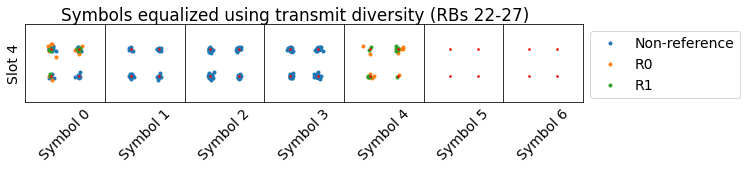

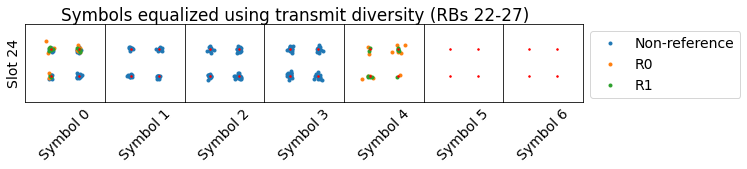

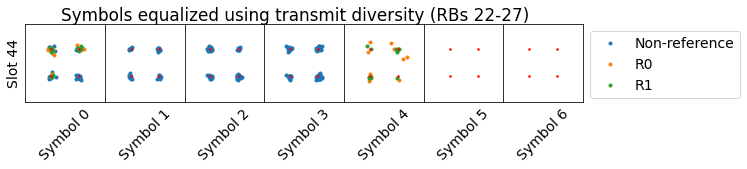

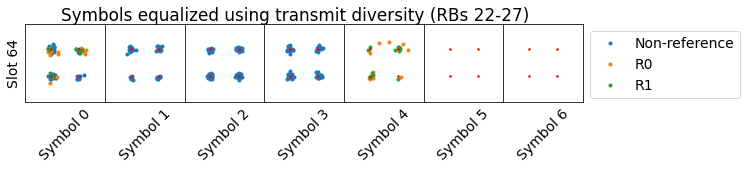

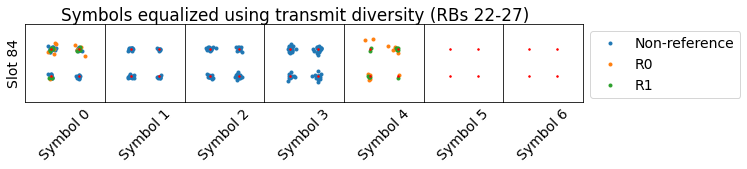

In [17]:
# Plots of the demodulation of a few PBCH transmissions
for start in range(28, nsymbols, 140)[:5]:
    diversity_plot(range(start, start+4), slice(22*12, 28*12), pbch=True)

## PBCH

In [18]:
# Demodulate all the PBCH transmissions
pbch = [diversity(
            remove_ref_signals(k, symbols[j+k, no_dc][22*12:28*12], pbch=True),
            remove_ref_signals(k, channel(j+k)[0][22*12:28*12], pbch=True),
            remove_ref_signals(k, channel(j+k)[1][22*12:28*12], pbch=True))
        for j in range(4*7, symbols.shape[0], 140) for k in range(4)]

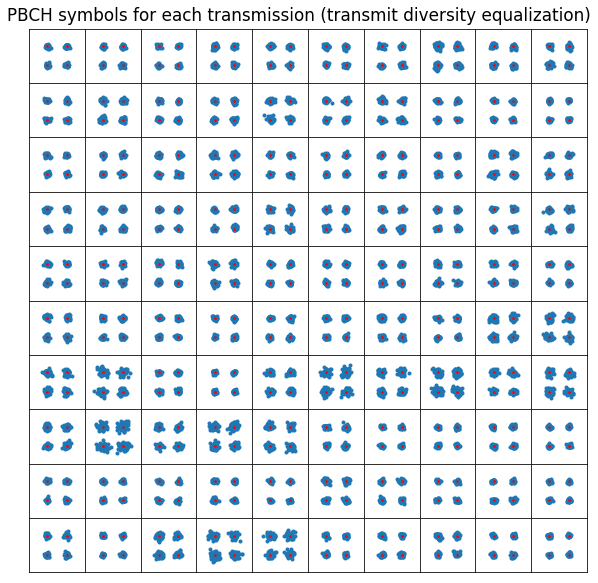

In [19]:
n = 10
fig, axs = plt.subplots(n, n, figsize=(10, 10), facecolor='w', sharex=True, sharey=True)
for j in range(n):
    for k in range(n):
        ax = axs[j, k]
        idx = n * j + k
        syms = np.concatenate(pbch[4*idx:4*(idx+1)])
        ax.plot(syms.real, syms.imag, '.')
        ax.plot(np.array([1, 1, -1, -1])/np.sqrt(2),
                np.array([1, -1, 1, -1])/np.sqrt(2), '.',
                color='red', markersize=3)
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('PBCH symbols for each transmission (transmit diversity equalization)', y=0.91);

## PDSCH equalization

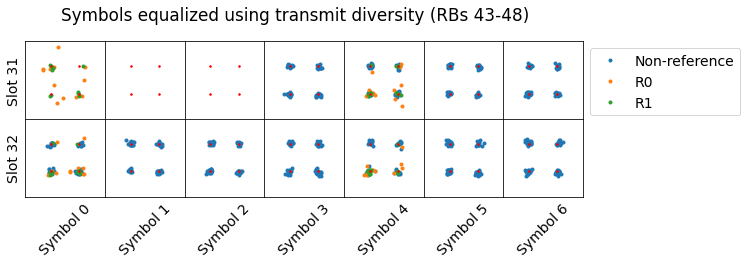

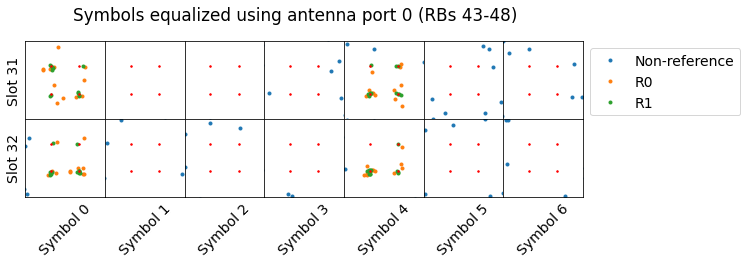

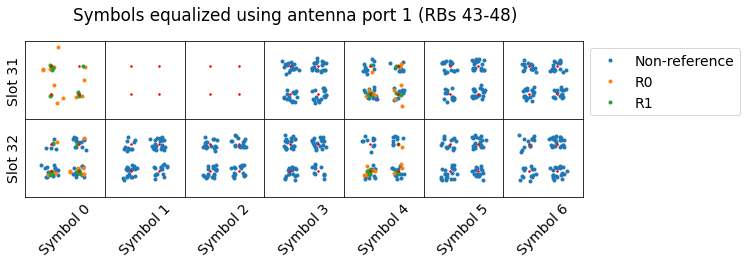

In [20]:
# Comparison of equalization of a PDSCH transmission using transmit diversity and only one antenna port
diversity_plot(range(220, 231), slice(-7*12, -12))
diversity_plot(range(220, 231), slice(-7*12, -12), transmit_port=0)
diversity_plot(range(220, 231), slice(-7*12, -12), transmit_port=1)

## PCFICH

In [21]:
# PCFICH demodulation
symidx0 = 7
npcfich = (nsymbols - symidx0)//14
pcfich = np.empty((npcfich, 16), 'complex')
symidx_pcfich = np.arange(symidx0, nsymbols, 14)
ns_pcfich = (symidx_pcfich // 7 + ns0) % 20
kbar = 6 * (pci % (2 * NRB))
for j, symidx in enumerate(symidx_pcfich):
    r0, r1 = channel(symidx)
    pcfich[j] = np.concatenate([
        diversity(
            remove_ref_signals(0, symbols[symidx, no_dc][(kbar+offset)%(12*NRB):][:6], pbch=True),
            remove_ref_signals(0, r0[no_dc][(kbar+offset)%(12*NRB):][:6], pbch=True),
            remove_ref_signals(0, r1[no_dc][(kbar+offset)%(12*NRB):][:6], pbch=True))
        for offset in [0, 6 * (NRB//2), 6 * (2*NRB//2), 6 * (3*NRB//2)]])

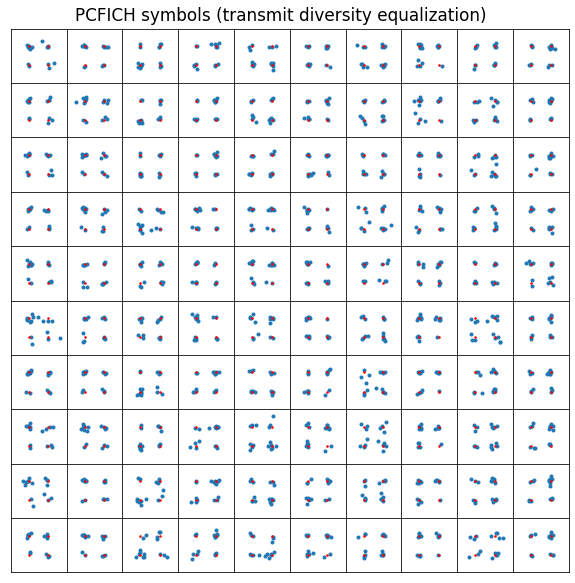

In [22]:
n = 10
fig, axs = plt.subplots(n, n, figsize=(10, 10), facecolor='w', sharex=True, sharey=True)
for j in range(n):
    for k in range(n):
        ax = axs[j, k]
        idx = n * j + k
        syms = pcfich[idx]
        ax.plot(syms.real, syms.imag, '.')
        ax.plot(np.array([1, 1, -1, -1])/np.sqrt(2),
                np.array([1, -1, 1, -1])/np.sqrt(2), '.',
                color='red', markersize=3)
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('PCFICH symbols (transmit diversity equalization)', y=0.91);

In [23]:
# PCFICH decoding using hard decision
pcfich_bits = 1 * (pcfich.astype('complex64').view('float32') < 0)
scramble = np.array([c_seq((ns//2 + 1) * (2 * pci + 1) * 2**9 + pci, 32)
                     for ns in ns_pcfich])
pcfich_descramble = pcfich_bits ^ scramble

In [24]:
# Table 5.3.4-1: CFI code words from 3GPP 36.212
cfi_codings = np.array(
    [[0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1],
     [1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0],
     [1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1]])

In [25]:
pcfich_bit_errors = np.sum(pcfich_descramble[:, np.newaxis, :] ^ cfi_codings, axis=-1)
pcfich_values = 1 + np.argmin(pcfich_bit_errors, axis=1)
pcfich_bit_errors = np.min(pcfich_bit_errors, axis=1)

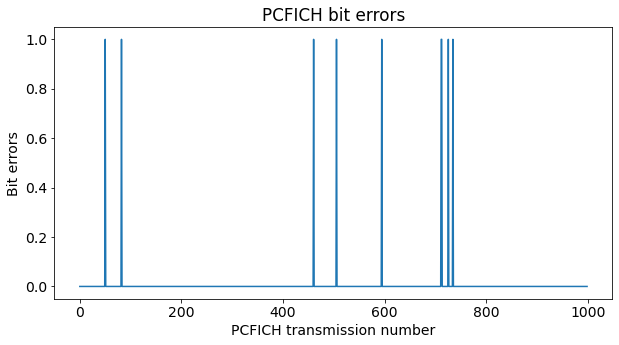

In [26]:
plt.plot(pcfich_bit_errors)
plt.title('PCFICH bit errors')
plt.ylabel('Bit errors')
plt.xlabel('PCFICH transmission number');

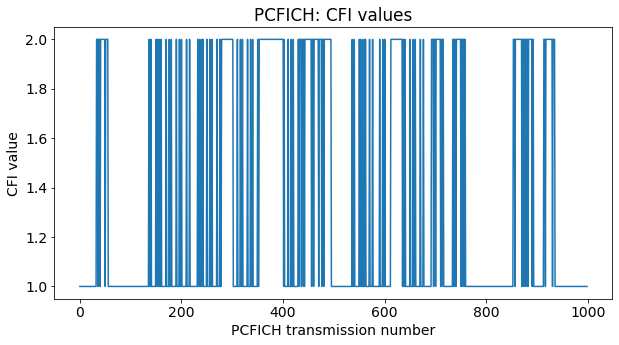

In [27]:
plt.plot(pcfich_values)
plt.title('PCFICH: CFI values')
plt.ylabel('CFI value')
plt.xlabel('PCFICH transmission number');

## PDSCH

In [28]:
# Compute PDSCH power in order to power-detect PDSCH allocations

rb_power = (np.abs(symbols[:, no_dc])**2)
# Blank PCFICH
kbar = 6 * (pci % (2 * NRB))
for offset in [0, 6 * (NRB//2), 6 * (2*NRB//2), 6 * (3*NRB//2)]:
    rb_power[7::14, (kbar+offset)%(NRB*12):][:, :6] = np.nan
rb_power = rb_power.reshape((-1, NRB, 12))
# Blank CRS
rb_power[::7, :, (pci%3)::3] = np.nan
rb_power[4::7, :, (pci%3)::3] = np.nan
# Blank PSS and SSS
rb_power[3*7+5::70, NRB//2-3:NRB//2+3] = 0
rb_power[3*7+6::70, NRB//2-3:NRB//2+3] = 0

# Blank PBCH
for j in range(4):
    rb_power[4*7+j::140, NRB//2-3:NRB//2+3] = 0
rb_power = np.nanmean(rb_power, axis=-1)

pdsch_power = rb_power.copy()
pdsch_power = pdsch_power[7:]  # Align to start of subframe
pdsch_power = pdsch_power.reshape(-1, 14, NRB)
# Blank control symbols according to CFI
pdsch_power[:, ::7] = np.nan
pdsch_power[pcfich_values == 2, 1::7] = np.nan
pdsch_power = np.nanmean(pdsch_power, axis=1)

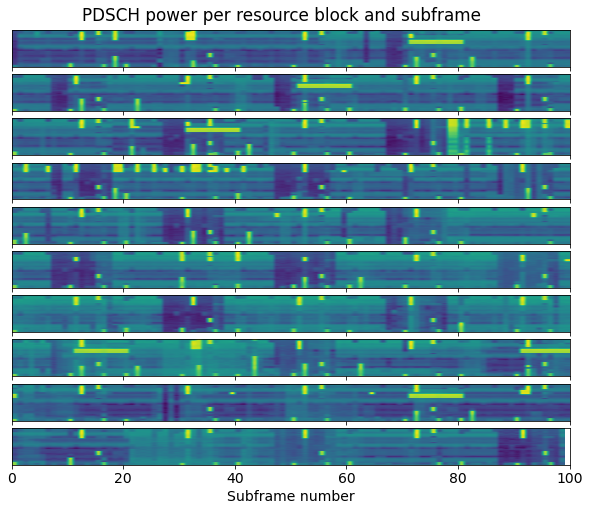

In [29]:
per_row = 100
fig, axs = plt.subplots(int(np.ceil(pdsch_power.shape[0]/per_row)), 1, 
                        figsize=(10, 8),
                        sharex=True, sharey=True)
for j, ax in enumerate(axs):
    a = pdsch_power[j*per_row:(j+1)*per_row, ::-1]
    ax.imshow(10*np.log10(a.T),
              aspect='auto', interpolation=None,
              extent=[0, a.shape[0], 0, NRB],
              vmin=10*np.log10(np.min(pdsch_power)),
              vmax=10*np.log10(np.max(pdsch_power)))
    ax.set_xlim((0, per_row))
    ax.set_yticks([])
axs[-1].set_xlabel('Subframe number');
plt.suptitle('PDSCH power per resource block and subframe', y=0.92);

In [30]:
cutoff = 0.03
pdsch_detect = pdsch_power >= cutoff

In [31]:
# Cluster PDSCH allocations in adjacent resource blocks in the same subframe

def cluster(x):
    clusters = []
    start = None
    for j, a in enumerate(x):
        if not a:
            if start is not None:
                clusters.append((start, j))
                start = None
        elif start is None:
            start = j
    if start is not None:
        clusters.append((start, j+1))
    return clusters

pdsch_allocations = []
for j, x in enumerate(pdsch_detect):
    for y in cluster(x):
        pdsch_allocations.append((j, y))

/tmp/ipykernel_2416/2723175641.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows, 7, figsize=(width, height), facecolor='w', sharex=True, sharey=True)


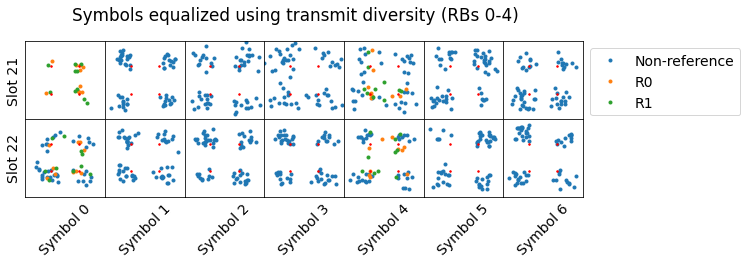

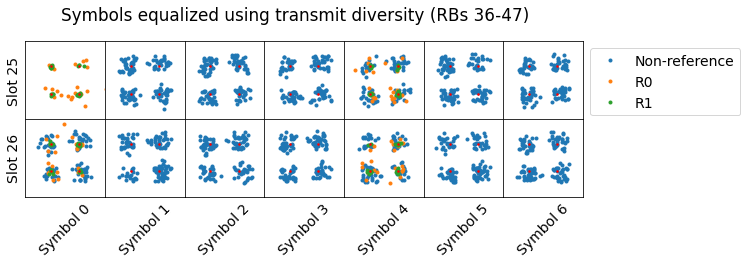

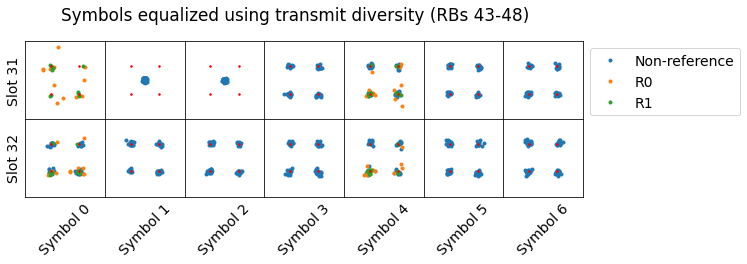

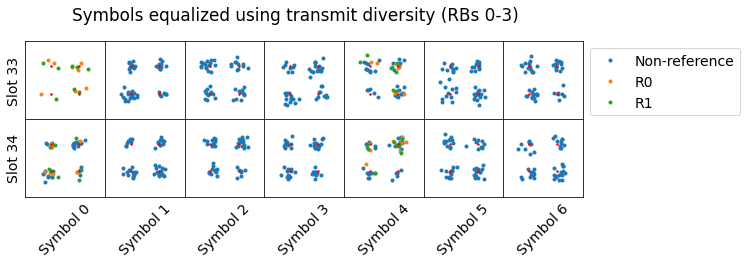

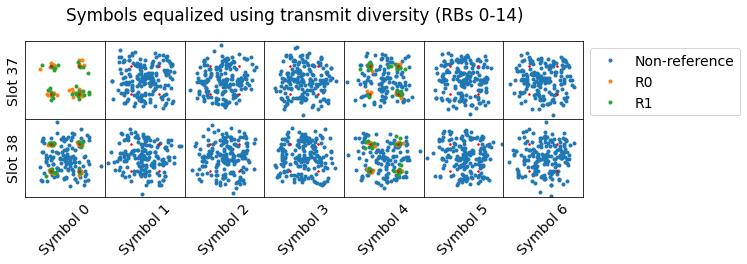

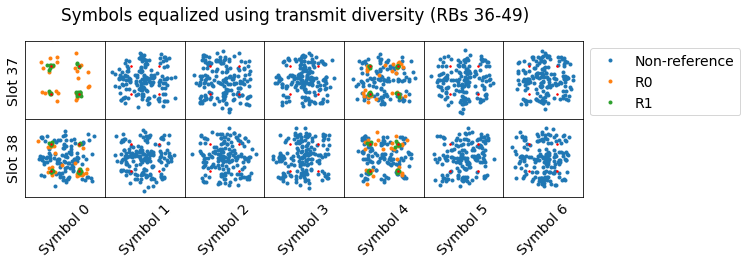

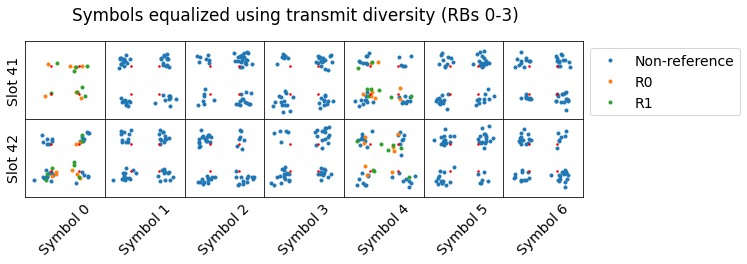

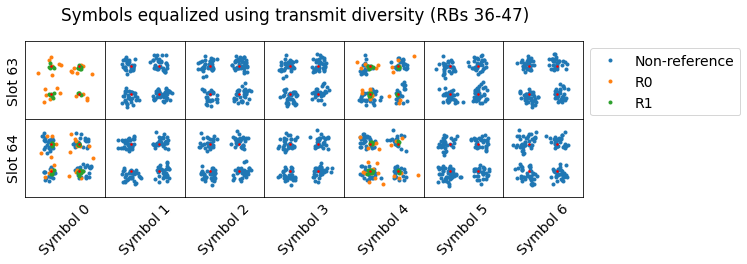

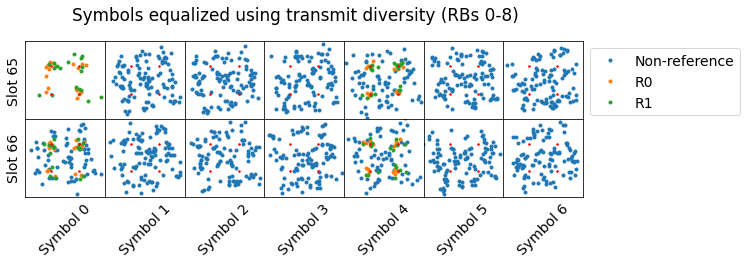

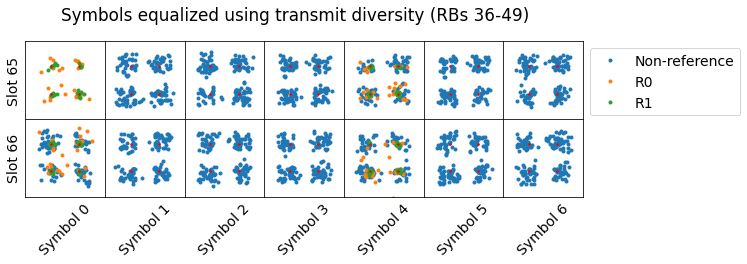

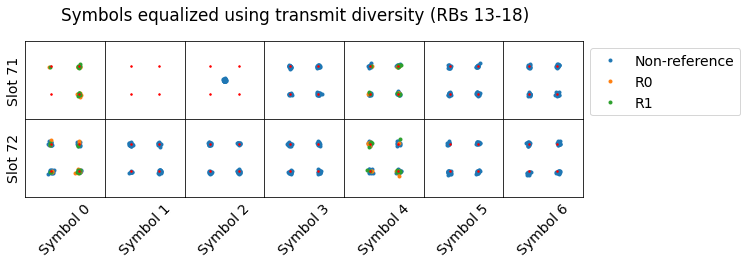

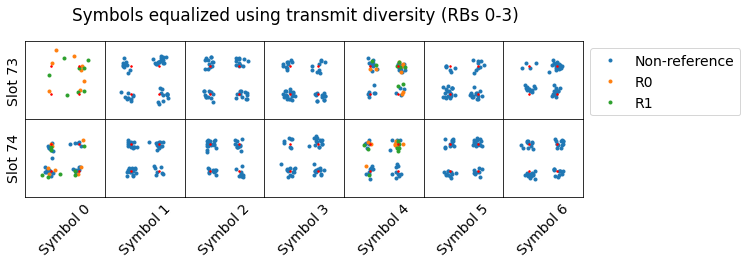

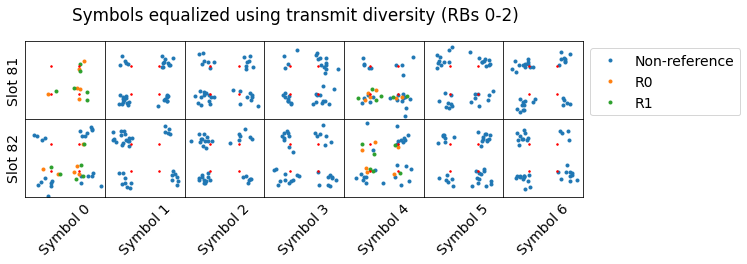

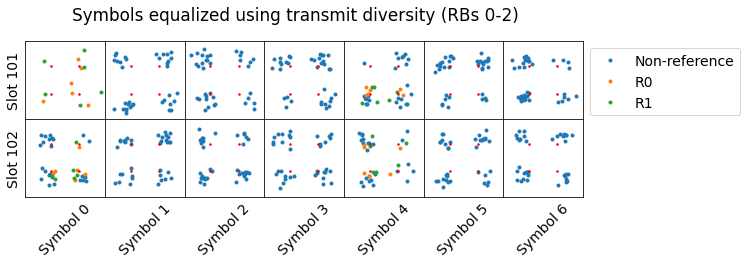

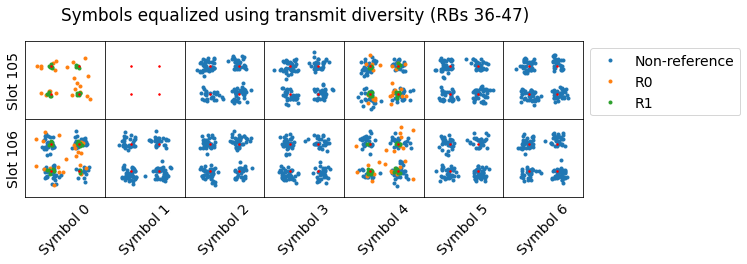

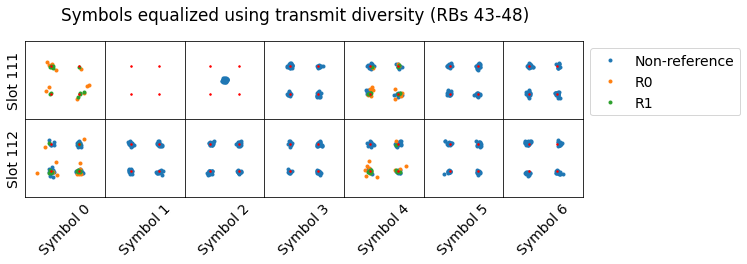

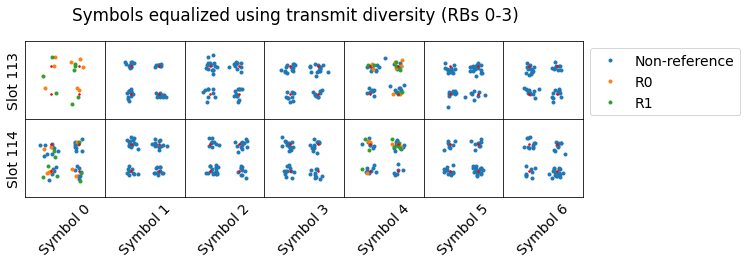

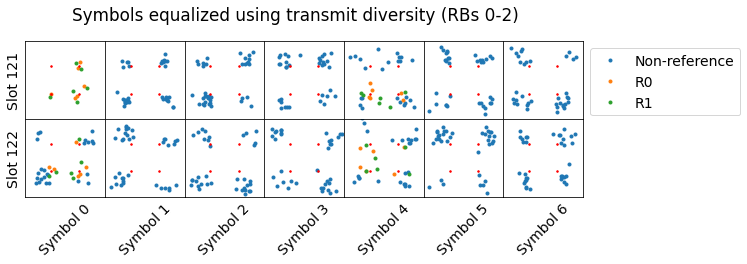

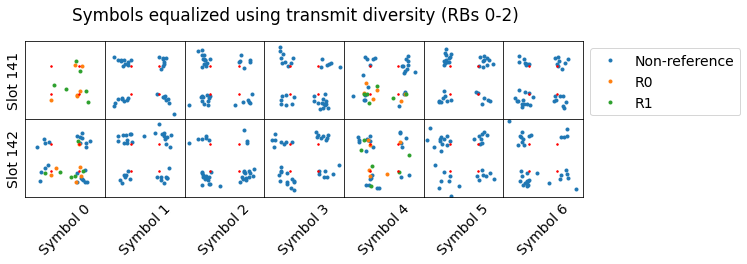

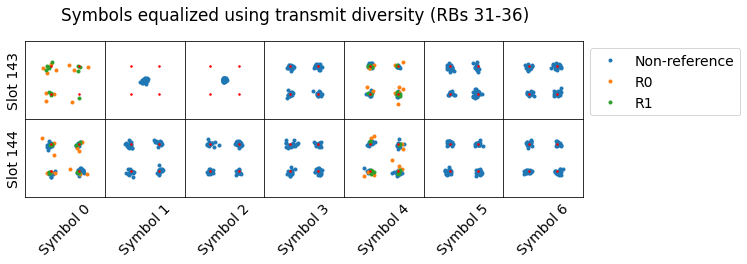

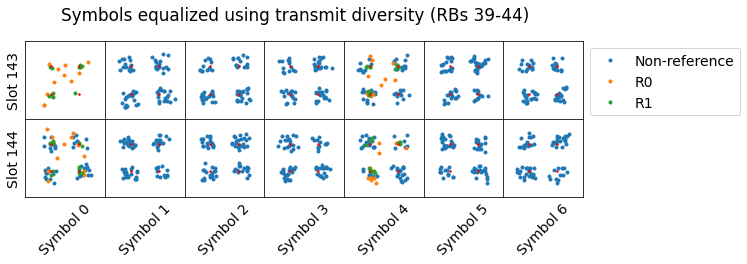

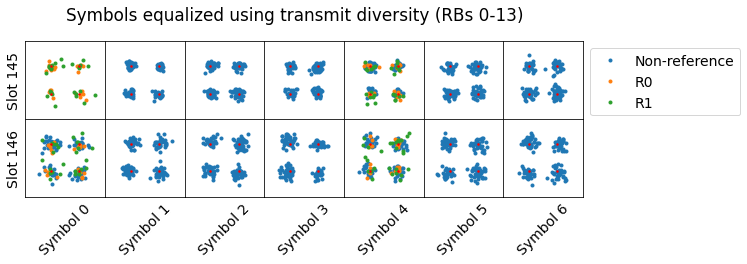

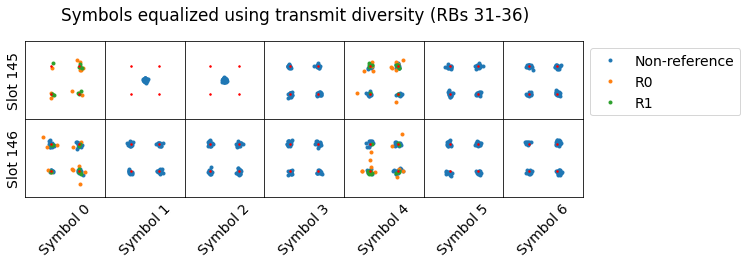

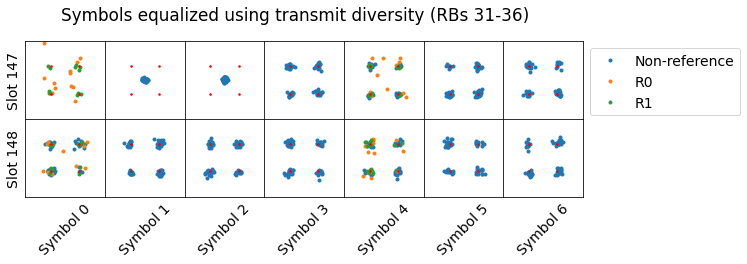

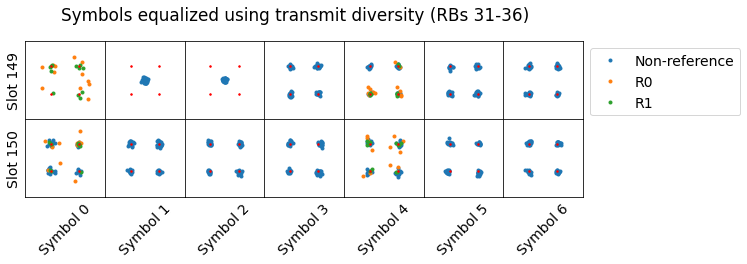

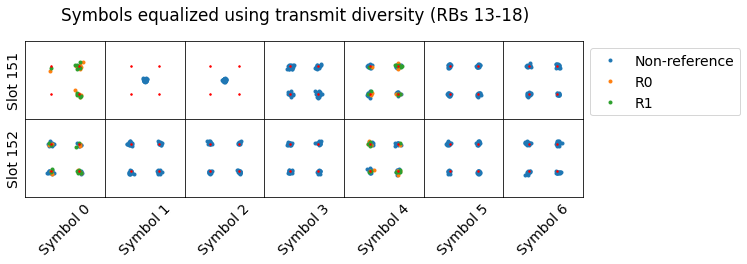

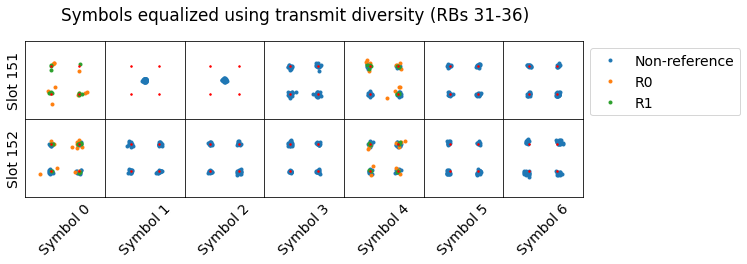

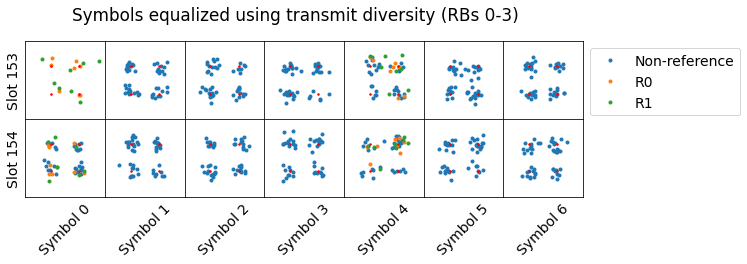

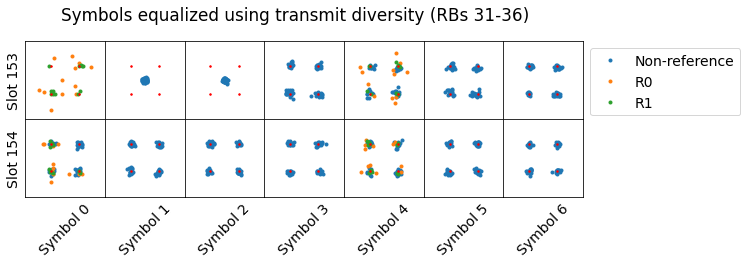

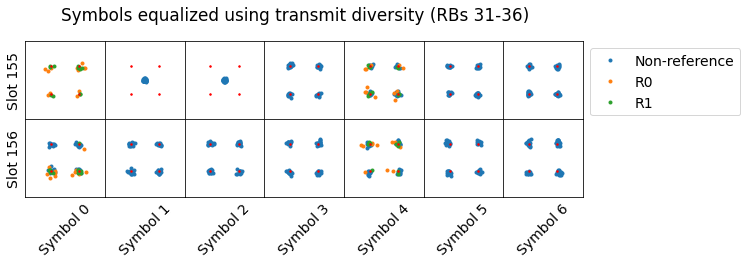

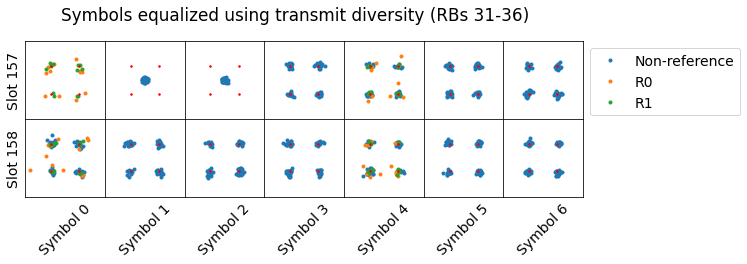

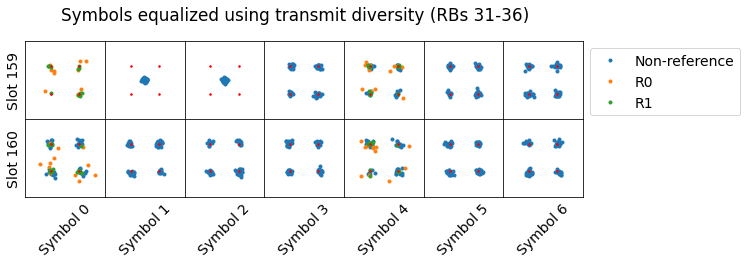

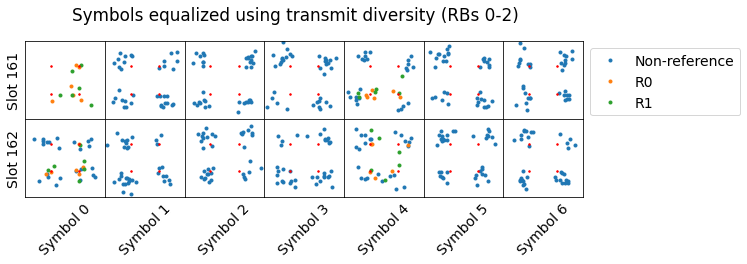

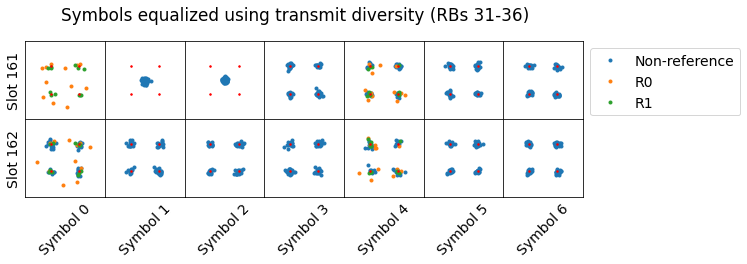

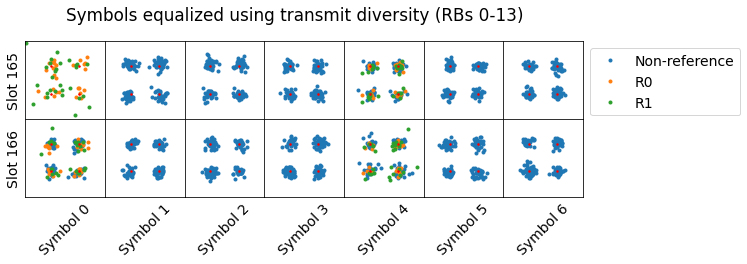

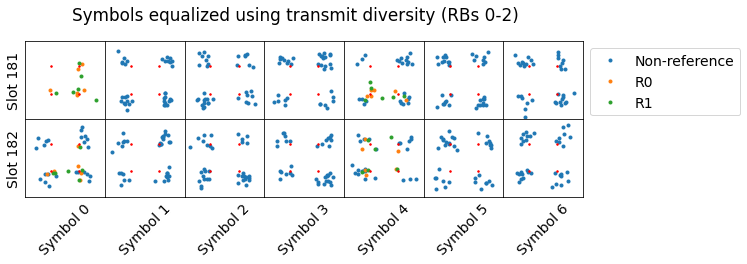

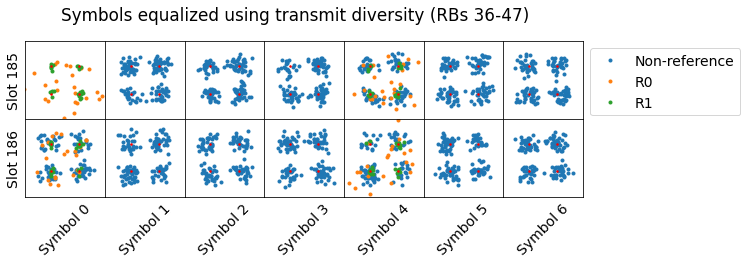

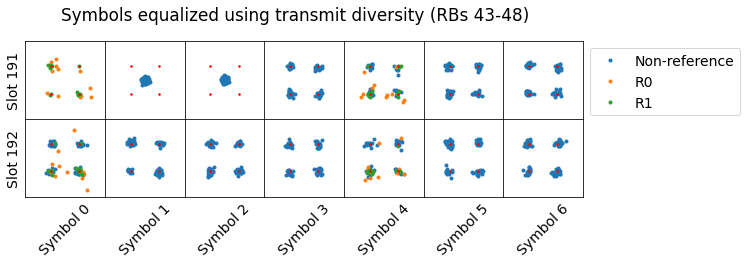

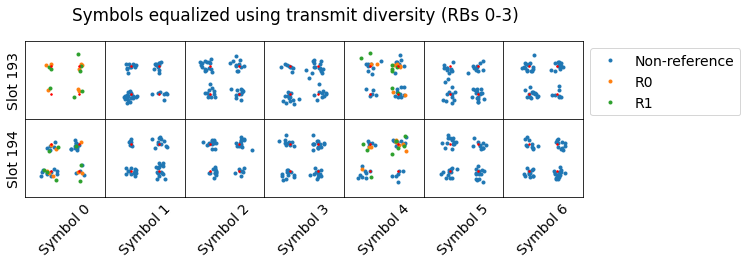

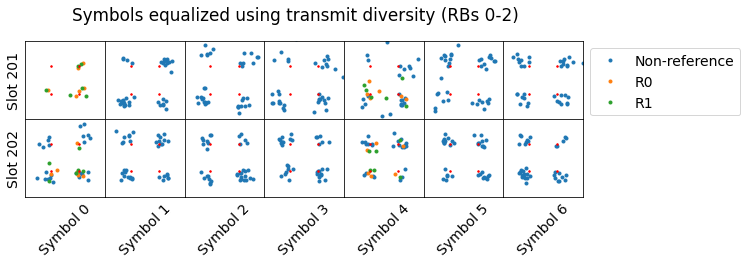

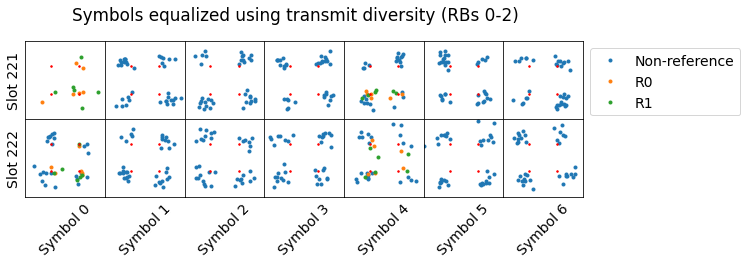

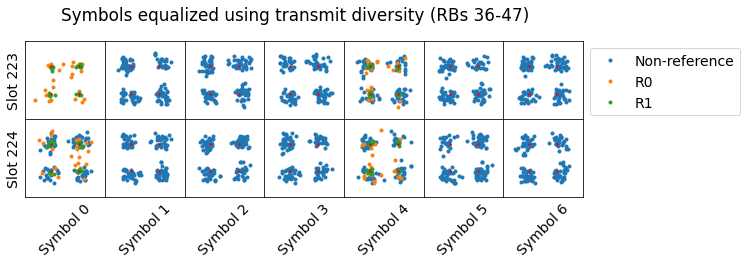

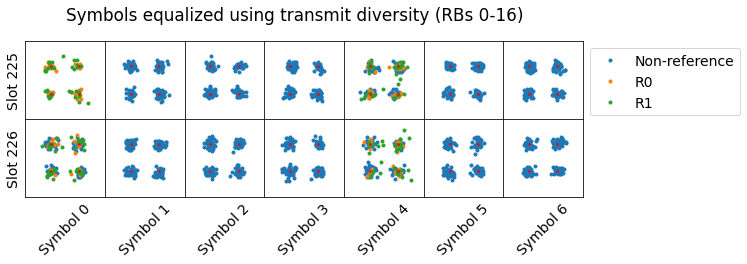

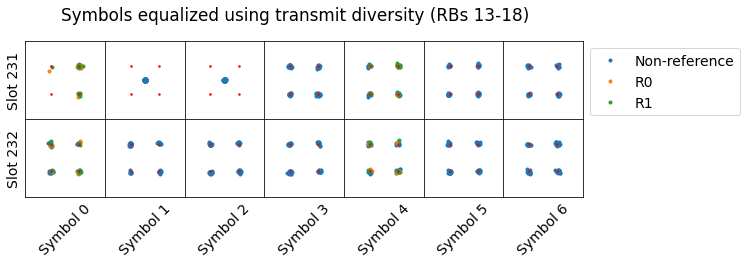

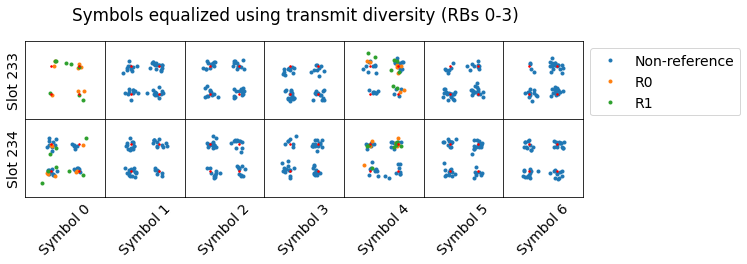

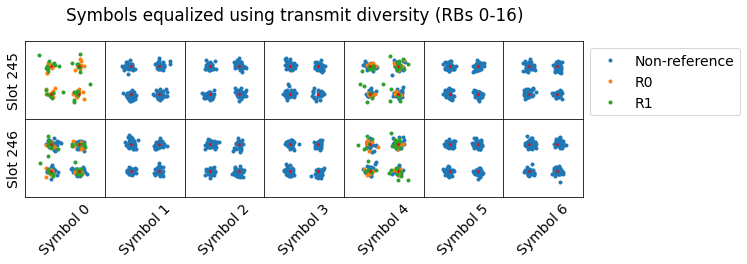

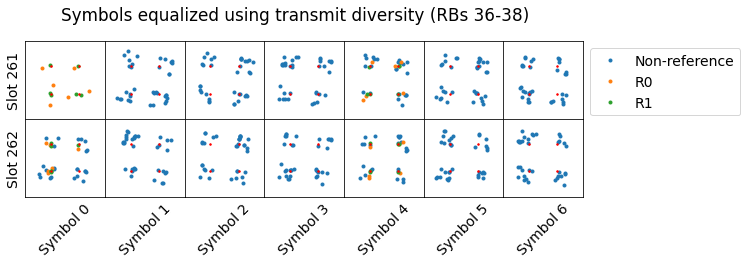

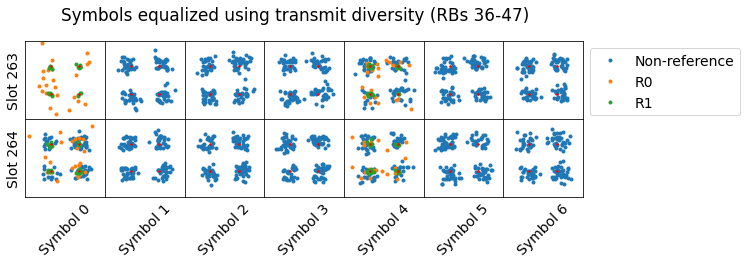

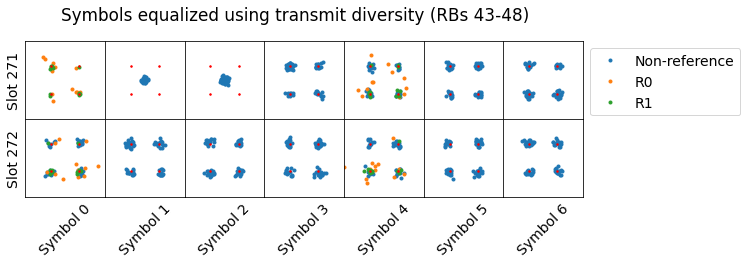

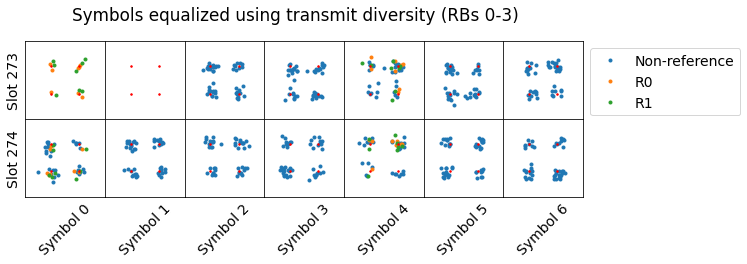

In [32]:
# Plot the demodulation of the first 50 PDSCH transmissions
for alloc in pdsch_allocations[:50]:
    sym0 = 7 + alloc[0] * 14 + pcfich_values[alloc[0]]
    sym_end = 7 + alloc[0] * 14 + 14 
    syms = range(sym0, sym_end)
    subcarriers = slice(alloc[1][0]*12, alloc[1][1]*12)
    diversity_plot(syms, subcarriers)

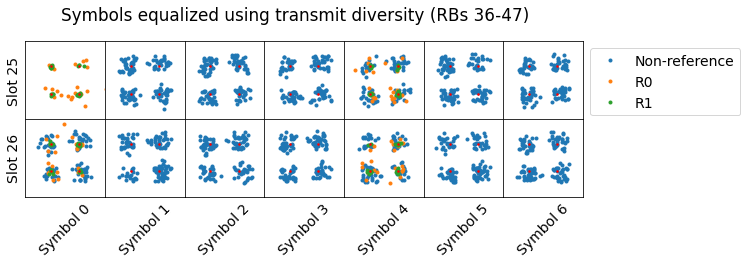

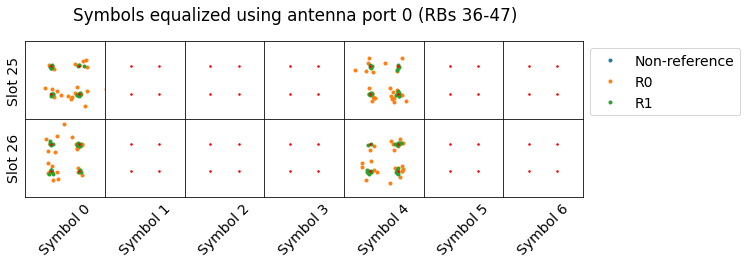

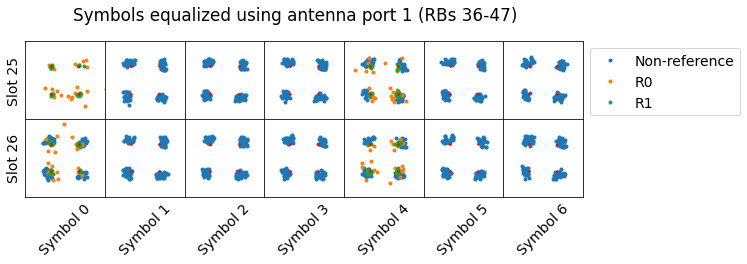

In [33]:
# Comparison of different equalizations for some transmissions
diversity_plot(range(176, 189), slice(-14*12, -2*12))
diversity_plot(range(176, 189), slice(-14*12, -2*12), transmit_port=0)
diversity_plot(range(176, 189), slice(-14*12, -2*12), transmit_port=1)

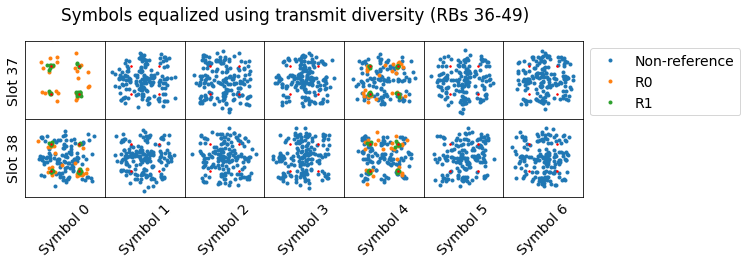

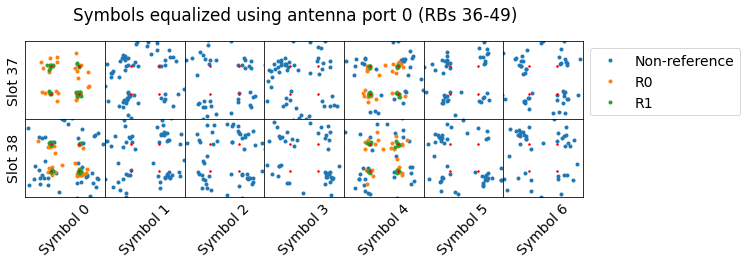

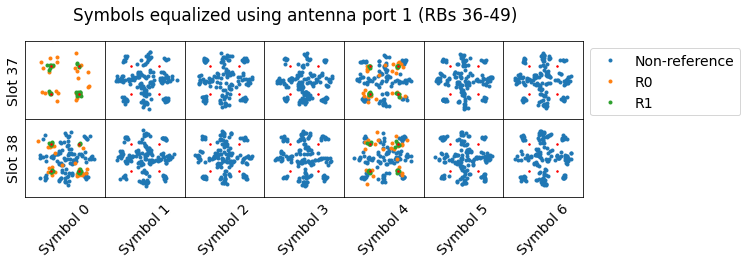

In [34]:
diversity_plot(range(260, 273), slice(-14*12, None))
diversity_plot(range(260, 273), slice(-14*12, None), transmit_port=0)
diversity_plot(range(260, 273), slice(-14*12, None), transmit_port=1)

## PHICH

In [35]:
n0 = 2 * NRB - 4  # number of REGs not allocated to PCFICH
Ng = 1
n_phich_groups = int(np.ceil(Ng * NRB / 8))
phich_offset = pci % n0
(n_phich_groups, phich_offset)

(7, 92)

In [36]:
pcfich_regs = (np.arange(4) * NRB // 2 + pci) % (2 * NRB)
avail_regs = np.array([reg for reg in np.arange(2 * NRB) if reg not in pcfich_regs])
phich_regs = np.array([avail_regs[(phich_offset + j + np.arange(3)*n0//3) % n0] for j in range(n_phich_groups)])
phich_regs

array([[96, 29, 63],
       [97, 31, 64],
       [98, 32, 65],
       [99, 33, 66],
       [ 0, 34, 67],
       [ 1, 35, 68],
       [ 2, 36, 69]])

In [37]:
reg_nsymbols = np.arange(7, symbols.shape[0], 14)
reg_symbols = np.empty((reg_nsymbols.size, 4 * 2 * NRB), 'complex')
for j, symidx in enumerate(reg_nsymbols):
    r0, r1 = channel(symidx)
    reg_symbols[j] = diversity(
        remove_ref_signals(0, symbols[symidx, no_dc], pbch=True),
        remove_ref_signals(0, r0[no_dc], pbch=True),
        remove_ref_signals(0, r1[no_dc], pbch=True))

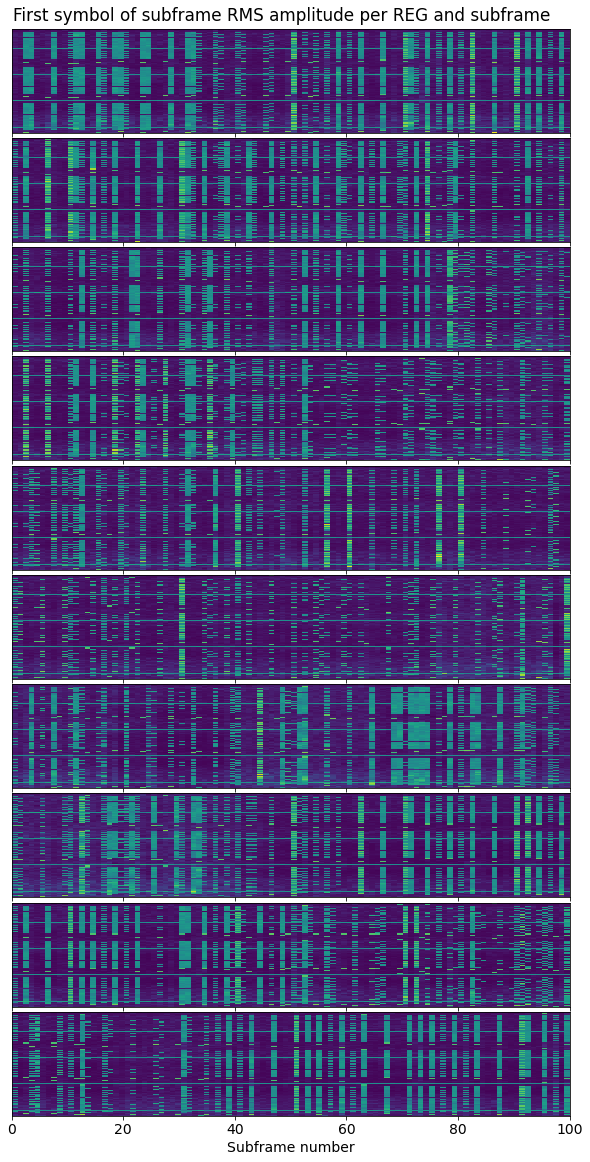

In [38]:
reg_rms = np.sqrt(np.average(np.abs(reg_symbols.reshape(-1, 2 * NRB, 4)**2), axis=-1))

fig, axs = plt.subplots(10, 1, figsize=(10, 20), sharex=True, sharey=True)
for j, ax in enumerate(axs):
    a = reg_rms[100*j:100*(j+1)].T[::-1]
    ax.imshow(a, vmin=0, vmax=2, aspect='auto', interpolation='none',
              extent=[0, a.shape[0], 0, 2*NRB])
    ax.set_xlim((0, 100))
    ax.set_yticks([])
axs[-1].set_xlabel('Subframe number');
fig.subplots_adjust(hspace=0.05)
plt.suptitle('First symbol of subframe RMS amplitude per REG and subframe', y=0.895);

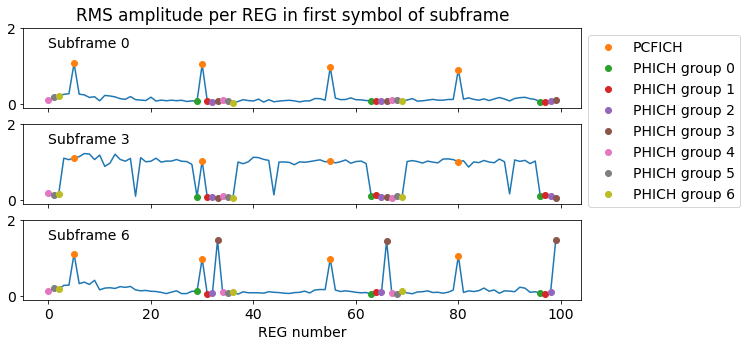

In [39]:
sfidxs = [0, 3, 6]
fig, axs = plt.subplots(len(sfidxs), 1, sharex=True, sharey=True)
for j, sfidx in enumerate(sfidxs):
    axs[j].plot(reg_rms[sfidx]);
    axs[j].plot(pcfich_regs, reg_rms[sfidx][pcfich_regs], 'o',
                label='PCFICH')
    for k, phich_r in enumerate(phich_regs):
        axs[j].plot(phich_r, reg_rms[sfidx][phich_r], 'o',
                    label=f'PHICH group {k}')
    axs[j].set_ylim((-0.1, 2))
    axs[j].text(0, 1.5, f'Subframe {sfidx}')
axs[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
axs[-1].set_xlabel('REG number')
plt.suptitle('RMS amplitude per REG in first symbol of subframe', y=0.94);

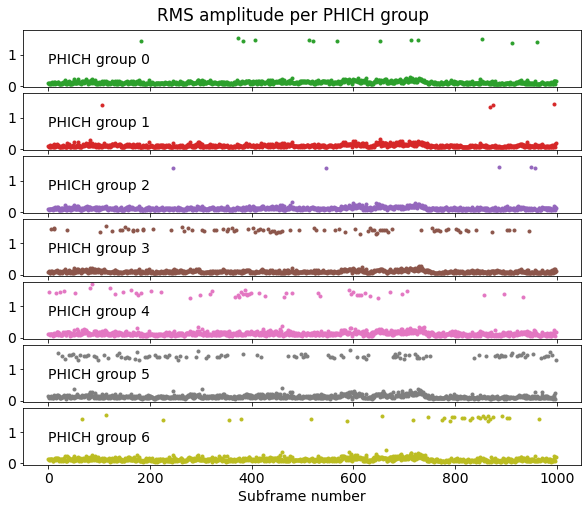

In [40]:
phich_rms = np.sqrt(np.average(reg_rms[:, phich_regs]**2, axis=-1))
fig, axs = plt.subplots(n_phich_groups, 1, sharex=True, sharey=True, figsize=(10, 8))
for j in range(n_phich_groups):
    axs[j].plot(phich_rms[:, j], '.', color=f'C{2+j}')
    axs[j].text(0, 0.7, f'PHICH group {j}')
fig.subplots_adjust(hspace=0.1)
axs[-1].set_xlabel('Subframe number')
plt.suptitle('RMS amplitude per PHICH group', y=0.92);

In [41]:
phich_active = phich_rms >= 0.7
np.sum(phich_active, axis=0) # number of PHICH transmissions per group

array([ 13,   4,   5,  87,  52, 114,  31])

In [42]:
W = np.array([[1, 1, 1, 1],
              [1, -1, 1, -1],
              [1, 1, -1, -1],
              [1, -1, -1, 1]]).T

phich_despread = np.empty((reg_rms.shape[0], n_phich_groups,  4), 'complex')
for sfidx, symidx in enumerate(reg_nsymbols):
    ns = (symidx // 7 + ns0) % 20
    scramble = c_seq((ns//2 + 1) * (2 * pci + 1) * 2**9 + pci, 12)
    scramble = 1 - 2 * scramble.astype('float')
    
    z = reg_symbols[sfidx].reshape(-1, 4)[phich_regs]
    z = (z.reshape(-1, 12) * scramble).reshape(-1, 3, 4)
    w = 0.25 * np.einsum('ij,kli->klj', W, z)
    phich_despread[sfidx] = np.average(w, axis=1)

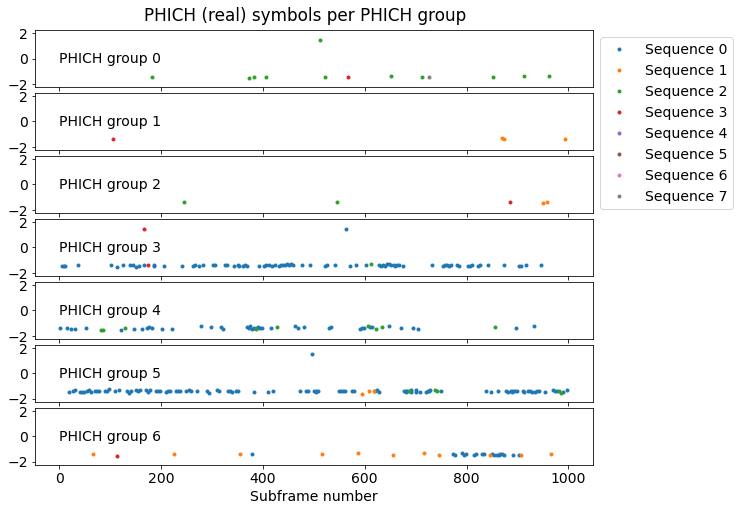

In [43]:
metric = np.real(phich_despread * np.exp(-1j*np.pi/4))
metric_imag = np.imag(phich_despread * np.exp(-1j*np.pi/4))
metric[np.abs(metric) < 0.5] = np.nan
metric_imag[np.abs(metric_imag) < 0.5] = np.nan
fig, axs = plt.subplots(n_phich_groups, 1, sharex=True, sharey=True, figsize=(10, 8))
for j in range(n_phich_groups):
    axs[j].plot(metric[:, j], '.')
    axs[j].plot(metric_imag[:, j], '.')
    axs[j].text(0, 0, f'PHICH group {j}',
                verticalalignment='center')
    axs[j].set_ylim((-2.25, 2.25))
fig.subplots_adjust(hspace=0.1)
axs[-1].set_xlabel('Subframe number')
axs[0].legend([f'Sequence {j}' for j in range(8)],
              bbox_to_anchor=(1, 1), loc='upper left')
plt.suptitle('PHICH (real) symbols per PHICH group', y=0.92);

In [44]:
np.sum(~np.isnan(metric) & (metric < 0), axis=0)

array([[  0,   0,  10,   1],
       [  0,   3,   0,   1],
       [  0,   2,   2,   1],
       [ 83,   0,   1,   1],
       [ 43,   0,   9,   0],
       [105,   3,   5,   0],
       [ 19,  11,   0,   1]])

In [45]:
np.sum(~np.isnan(metric) & (metric > 0), axis=0)

array([[0, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 1],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0]])

In [46]:
np.sum(~np.isnan(metric_imag) & (metric_imag < 0), axis=0)

array([[0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [47]:
np.sum(~np.isnan(metric_imag) & (metric_imag > 0), axis=0)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [48]:
np.where(~np.isnan(metric_imag))[0]

array([727])

In [49]:
# Positions where two sequence numbers are used in the same group
np.where(np.sum((~np.isnan(metric)).astype('int')
                + (~np.isnan(metric_imag)).astype('int'), axis=-1)  > 1)

(array([], dtype=int64), array([], dtype=int64))

In [50]:
# Subframes where two groups are used at the same time
coincident_groups = np.where(np.sum((~np.isnan(metric)).astype('int')
                + (~np.isnan(metric_imag)).astype('int'), axis=(-1, -2))  > 1)[0]
coincident_groups

array([114, 182, 373, 378, 383, 407, 628, 652, 869, 874, 907, 912])

In [51]:
np.sum(~np.isnan(metric[coincident_groups]), axis=(-1, -2))

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

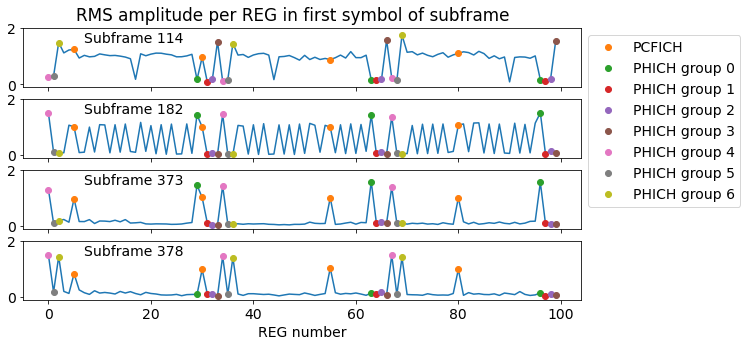

In [52]:
sfidxs = [114, 182, 373, 378]
fig, axs = plt.subplots(len(sfidxs), 1, sharex=True, sharey=True)
for j, sfidx in enumerate(sfidxs):
    axs[j].plot(reg_rms[sfidx]);
    axs[j].plot(pcfich_regs, reg_rms[sfidx][pcfich_regs], 'o',
                label='PCFICH')
    for k, phich_r in enumerate(phich_regs):
        axs[j].plot(phich_r, reg_rms[sfidx][phich_r], 'o',
                    label=f'PHICH group {k}')
    axs[j].set_ylim((-0.1, 2))
    axs[j].text(7, 1.5, f'Subframe {sfidx}')
axs[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
axs[-1].set_xlabel('REG number')
plt.suptitle('RMS amplitude per REG in first symbol of subframe', y=0.94);

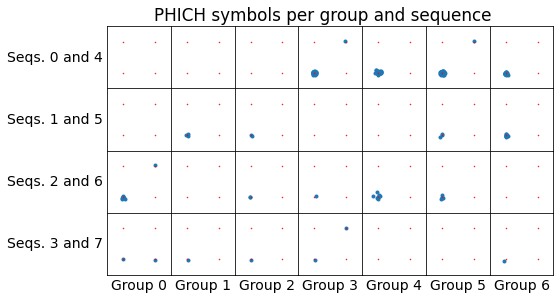

In [53]:
fig, axs = plt.subplots(4, n_phich_groups, figsize=(8, 8*4/n_phich_groups),
                        facecolor='w', sharex=True, sharey=True)
for j in range(4):
    for k in range(n_phich_groups):
        ax = axs[j, k]
        z = phich_despread[:, k, j].copy()
        z[np.abs(z) < 0.5] = np.nan
        ax.plot(z.real, z.imag, '.')
        ax.plot(np.array([1, 1, -1, -1]),
                np.array([1, -1, 1, -1]), '.',
                color='red', markersize=1)
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
for j in range(4):
    axs[j, 0].set_ylabel(f'Seqs. {j} and {j+4}', rotation=0,
                         horizontalalignment='right', verticalalignment='center')
for j in range(n_phich_groups):
    axs[-1, j].set_xlabel(f'Group {j}')
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('PHICH symbols per group and sequence', y=0.94);